In [78]:
# load data
import numpy as np
import pandas as pd

# dataset taken from: https://www.kaggle.com/datasets/miadul/kidney-function-health-dataset/data
df = pd.read_csv("C:/Users/sharo/OneDrive/Documents/sharon/ML/kidney_dataset.csv")
df_raw = df.copy()

In [79]:
df.shape

(5000, 11)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Creatinine        5000 non-null   float64
 1   BUN               5000 non-null   float64
 2   GFR               5000 non-null   float64
 3   Urine_Output      5000 non-null   float64
 4   Diabetes          5000 non-null   int64  
 5   Hypertension      5000 non-null   int64  
 6   Age               5000 non-null   float64
 7   Protein_in_Urine  5000 non-null   float64
 8   Water_Intake      5000 non-null   float64
 9   Medication        2013 non-null   object 
 10  CKD_Status        5000 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 429.8+ KB


In [81]:
df.isnull().sum()

Creatinine             0
BUN                    0
GFR                    0
Urine_Output           0
Diabetes               0
Hypertension           0
Age                    0
Protein_in_Urine       0
Water_Intake           0
Medication          2987
CKD_Status             0
dtype: int64

In [82]:
df.describe()

,Creatinine,BUN,GFR,Urine_Output,Diabetes,Hypertension,Age,Protein_in_Urine,Water_Intake,CKD_Status
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.994088,30.780063,73.251883,1664.302800,0.294000,0.378200,50.048733,537.053851,2.504335,0.263000
std,2.027013,31.148341,31.972399,599.384655,0.455637,0.484986,14.492020,817.510451,0.868925,0.440306
min,0.600040,7.007732,5.000000,400.502554,0.000000,0.000000,18.000000,50.010471,1.000810,0.000000
25%,0.801333,11.367599,53.036801,1105.890821,0.000000,0.000000,40.190016,83.692533,1.744138,0.000000
50%,1.007629,15.878566,89.555882,1814.499690,0.000000,0.000000,49.942824,119.492591,2.511710,0.000000
75%,2.163997,40.636666,93.989273,2146.441778,1.000000,1.000000,59.761132,588.428649,3.268812,1.000000
max,7.996428,119.931652,105.451432,2499.939696,1.000000,1.000000,90.000000,2997.724192,3.998043,1.000000


From given dataset, "na" values in Medication are supposed to represent "No medication taken". We fill in the missing values accordingly.

In [83]:
df["Medication"] = df["Medication"].fillna("None")
df["Medication"].unique()

array(['None', 'ACE Inhibitor', 'Diuretic', 'ARB'], dtype=object)

The columns can be grouped into:
1. Risk factors (e.g. medical conditions, daily habits)
2. Blood test results, which can indicate chronic kidney disease

Hypothesis: Blood test results are better indicators of CKD status than the other risk factors.   
Since if an individual has CKD, this will likely show up in blood test results.  
On the other hand, the CKD positive individual may not have any presenting risk factors. 

In [84]:
risk_factors = ["Diabetes", "Hypertension", "Age", "Water_Intake", "Medication"]
test_results = ["Creatinine", "BUN", "GFR", "Urine_Output", "Protein_in_Urine"]

num_columns = df.select_dtypes(include="float64").columns.tolist()
cat_columns = df.select_dtypes(include=["int64", "object"]).columns.tolist()

Next, we perform univariate analysis:

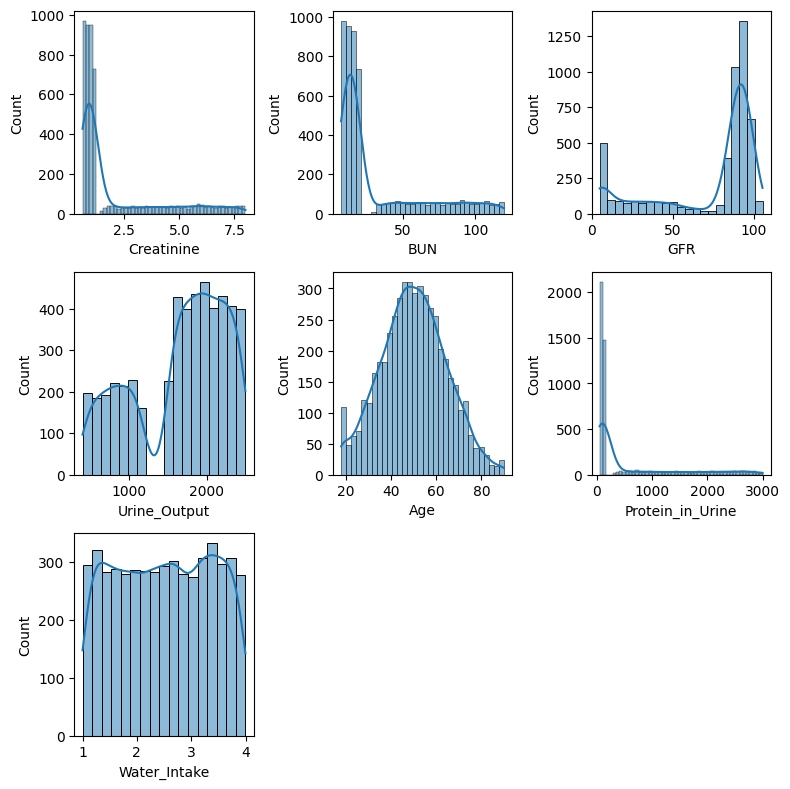

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate analysis of numerical features
plt.figure(figsize=(8,8))
for index, num_column in enumerate(num_columns, start=1):
    plt.subplot(3, 3, index)
    sns.histplot(df[num_column], kde=True)

plt.tight_layout()
plt.show()


From above histogram plots, we observe:
- Right-skewed distributions for Creatinine, BUN and Protein_in_Urine. 
  Expected since normal levels of Creatinine, BUN and Protein_in_Urine is low, whist high levels are considered abnormal.   
  Implication on ML pipeline:
    - Feature engineering: Unlikely that log-transformation will be useful, since this would reduce the impact of extreme values on the ML model.  
      Can still run ML model twice - once with log-transformed values, and once with original values. <br><br>  
- Normal distribution for Age

- Near constant distribution for Water_Intake

- Bimodal distributions for Urine_Output and GFR, suggesting there may be 2 sub-populations.   
  There is a clear distinction between both subpopulations for Urine_Output.   
  Implication on ML pipeline:   
  - Feature engineering: Split Urine_Output and GFR into subpopulations.

<Figure size 400x400 with 0 Axes>

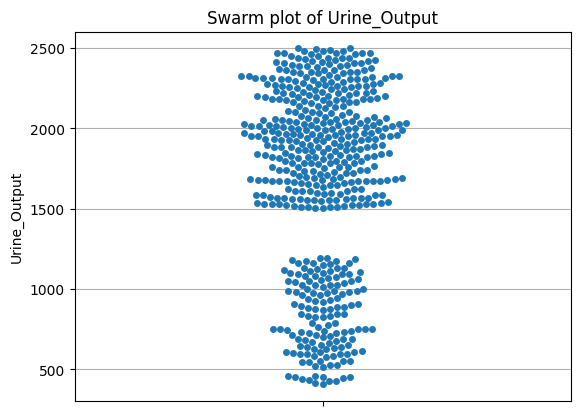

In [86]:
# Find separator for subpopulations of Urine_Output
sample_df = df.sample(frac=0.1)
plt.figure(figsize=(4,4))
fig, ax = plt.subplots()
ax.grid(True)
sns.swarmplot(y="Urine_Output", data=sample_df)
plt.title("Swarm plot of Urine_Output")
plt.show()

By observation, the data for Urine_Output can be split into 2 groups: <1300 and >=1300 (mL/day). <br>      
Implication on ML pipeline:
- Feature engineering: Construct flag variable for (Urine_Output >= 1300).

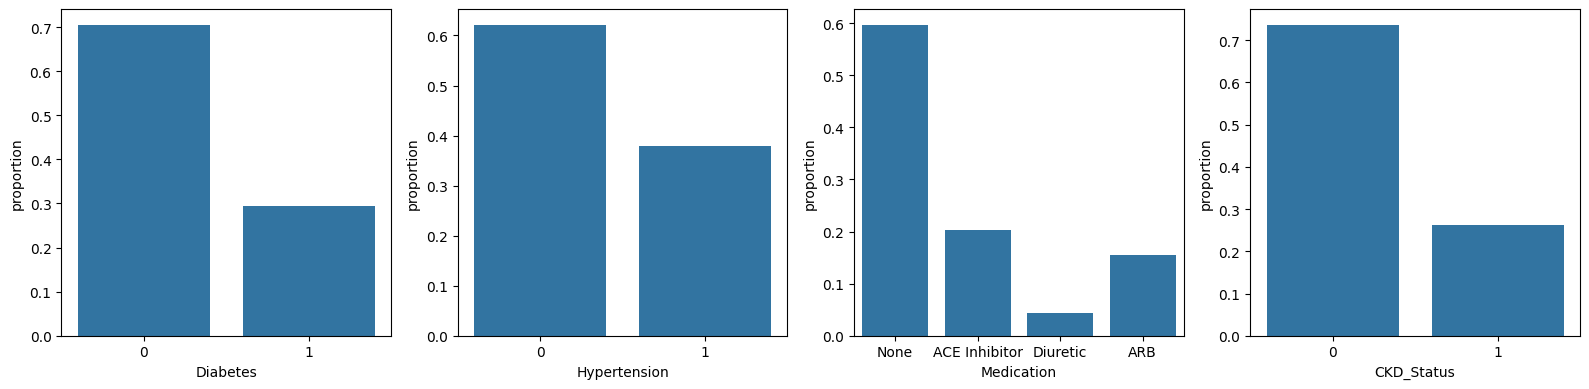

In [87]:
# Univariate analysis of categorical features
plt.figure(figsize=(16, 4))
for index, cat_column in enumerate(cat_columns, start=1):
    plt.subplot(1, 4, index)
    sns.countplot(data=df, x=cat_column, stat="proportion")

plt.tight_layout()
plt.show()
    

All categorical features have significant class imbalances.   
For Medication, the category "Diuretic" is underrepresented.   

Implication on ML pipeline:   
- Feature engineering: Can consider frequency encoding - in case the frequency of a category is predictive too.  
- Model selection: ML model trained may become biased towards the majority class, resulting in poor prediction results.   
                   Preferable to use tree-based models like Random Forest.   
- Model evaluation metric: Do not use accuracy.  

Next, we perform multivariate analysis:

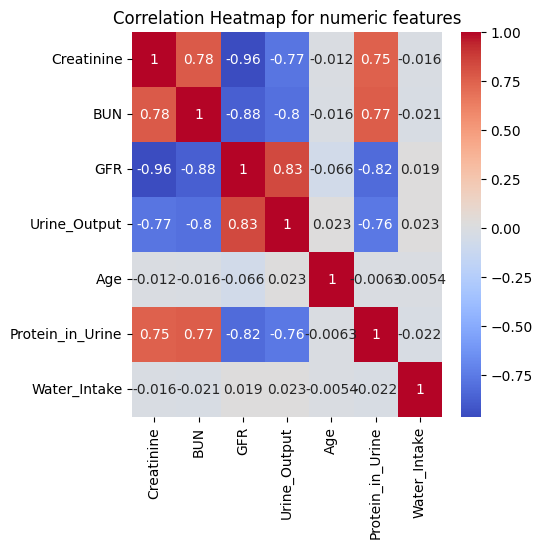

In [88]:
# Multivariate analysis for numerical features
num_df = df[[col for col in num_columns]]
plt.figure(figsize=(5,5))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap for numeric features")
plt.show()

There are strong correlations between:
- Creatinine vs GFR
- BUN vs GFR
- GFR vs Urine_Output
- Protein_in_Urine vs Creatinine, BUN, GFR, Urine_Output.   
  Expected since presence of high levels of either of (Creatinine, BUN, Protein_in_Urine) or low levels of (GFR, Urine_Output)  
  indicates possible reduced kidney function, and thus likely co-occurs with the remaining abovementioned symptoms.  

Implication on ML pipeline:
- Feature engineering: Can create a new variable representing feature interactions between Protein_in_Urine, Creatinine, BUN, GFR, Urine_Output.   
                       Or a subset of these. Amongst these, Protein_in_Urine/Creatinine ratio and BUN/Creatinine ratio are commonly used as clinical tests.  